In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from __future__ import print_function

import os

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio
import gdal
from rasterio.plot import show
from rasterio.plot import plotting_extent
import numpy as np
import pandas as pd
import time
import matplotlib.colors

try:
    import keras
    from imblearn.keras import balanced_batch_generator
    from imblearn.under_sampling import NearMiss
    import keras.backend as K
    from keras.models import Sequential
    from keras.models import model_from_json
    from keras.layers import Dense, Dropout, Activation
    from keras.optimizers import RMSprop
    from keras.optimizers import Adam
    from keras.optimizers import Adagrad
    from keras.optimizers import SGD
    from keras.callbacks import LambdaCallback, ReduceLROnPlateau, ModelCheckpoint
    from keras.layers.core import Lambda
    from keras.losses import categorical_crossentropy
    import tensorflow as tf
    from keras import regularizers

except:
    print("Keras not found")
    
np.random.seed(42)


def my_basename(path):
    return os.path.splitext(os.path.split(path)[1])[0]

file_dir=r'C:/Users/Mark.Rademaker/PycharmProjects/InternshipNaturalis/trait-geo-diverse-dl/data_GIS_extended'

Using TensorFlow backend.


#### Trial alternative dataset construction for faster execution

Create input dataset for entire globe

In [3]:
##opening raster as 3d numpy array
inRas=gdal.Open(file_dir+'/data/GIS/env_stacked/stacked_env_variables.tif')
myarray=inRas.ReadAsArray()
print(myarray.shape)
print(type(myarray))


(186, 1800, 4320)
<class 'numpy.ndarray'>


In [ ]:
#get all col and row values for all cells on land 
df=pd.read_csv(file_dir+'/data/GIS/world_locations_to_predict.csv')
len_pd=np.arange(len(df))
print(len_pd)
lon=df["decimal_longitude"]
lat=df["decimal_latitude"]
lon=lon.values
lat=lat.values

row=[]
col=[]

src=rasterio.open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif')

for i in len_pd:
    row_n, col_n = src.index(lon[i], lat[i])# spatial --> image coordinates
    row.append(row_n)
    col.append(col_n)

In [ ]:
#collect file with mean and std_dev for each band
mean_std=pd.read_csv(file_dir+'/data/GIS/env_bio_mean_std.txt',sep="\t")
mean_std=mean_std.to_numpy()


#################################
#extract the values for all bands and prepare input data
#################################
X=[]

for j in range(0,41):
    print(j)
    #start2=time.time()
    band=myarray[j]
    x=[]

    for i in range(0,len(row)):
        value= band[row[i],col[i]]
        if value <-1000:
            value=np.nan
            x.append(value)
        else:
            value = ((value - mean_std.item((j,1))) / mean_std.item((j,2)))#scale values
            x.append(value)
    #end2=time.time()
    #print(j,start2-end2)
    X.append(x)

#include row and column values
X.append(row)
X.append(col)
#set as numpy 2d array
X =np.array([np.array(xi) for xi in X])

df=pd.DataFrame(X)

df=df.T
df=df.dropna(axis=0, how='any')
input_X=df.loc[:,0:40]


row=df[41]
col=df[42]

#convert dataframe back to numpy array
input_X=input_X.values
#convert rows and col indices back to array
row=row.values
col=col.values

#save
prediction_array=np.save(file_dir+'/data/prediction_arrays/%s_prediction_array.npy'%spec,input_X)

Predict species specific model on input dataset

In [66]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/results/_DNN_performance/DNN_eval.txt",sep="\t")
taxa=taxa["Species"]

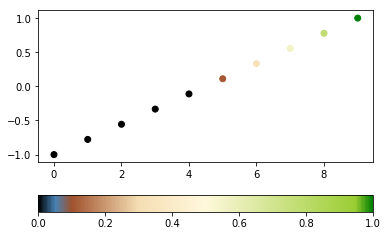

In [62]:
#create colormap for maps
norm = matplotlib.colors.Normalize(0,1)
colors = [[norm(0), "black"],
            [norm(0.05),"steelblue"],
         # [norm(0.05), "brown"],
         # [norm(0.5), "yellow"],
          [norm(0.1),"sienna"],
          [norm(0.3),"wheat"],
          [norm(0.5),"cornsilk"],#0.2
          [norm(0.95),"yellowgreen"],
          [norm(1.0),"green"]]
          #[norm(1.0),"black"]]
          #[norm(1.0),"black"]]
          #[norm(1.0),"black"]]#,
          #[norm(1.0), "white"]]#,
          #[norm(1.0), "lightgreen"]]

custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
custom_cmap.set_bad(color="white")

fig, ax=plt.subplots()
x = np.arange(10)
y = np.linspace(-1,1,10)
sc = ax.scatter(x,y, c=y, norm=norm, cmap=custom_cmap)
fig.colorbar(sc, orientation="horizontal")
plt.show()

In [6]:
###column variable names
with open(file_dir+'/data/GIS/env_stacked/variable_list.txt') as f:
      new_cols = f.readlines()

var_names=[]
for item in new_cols:
    item=item.replace("\n","")
    var_names.append(item) 

len(var_names)
#print(var_names)

186

In [68]:
###create an index of the continental borders and coastal, lake cells that should be excluded from prediction
###clay percentage raster has higest resolution outline
src=rasterio.open(file_dir+'/data/GIS/5_deg/Aspect_5deg.tif')
b=src.read(1)
minb=np.min(b)
index_minb1=np.where(b==minb)

src=rasterio.open(file_dir+'/data/GIS/5_deg/ClayPercentage_5min.tif')
b=src.read(1)
minb=np.min(b)
index_minb2=np.where(b==minb)


In [ ]:
%%capture
#import time

for species in taxa[:]:
#start=time.time()
#set the species 
    spec=species
    print("processing", spec)
    spec=spec.replace(" ","_")
    spec_index=var_names.index("%s_presence_map"%spec)
    print(spec_index)

    ################################################################################################
    ################################################################################################
    #   run the predictions 
    ################################################################################################
    ################################################################################################

    input_X=np.load(file_dir+'/data/GIS/world_prediction_array.npy')#%spec)
    np.shape(input_X)
    #remove values for variable species presence map based on index
    input_X=np.delete(input_X,[spec_index],1)
    np.shape(input_X)
    
    #create copy of band to later subset values in
    new_band=myarray[1].copy()
    new_band.shape


    ### Load DNN model for the species and predict values:
    #load json and create model
    json_file = open(file_dir+'/results/{}/{}_model.json'.format(spec,spec),'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    #load weights into new model
    loaded_model.load_weights(file_dir+'/results/{}/{}_model.h5'.format(spec,spec))
    #print('Loaded model from disk')

    #compile model
    loaded_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

    #predict values
    new_values = loaded_model.predict(x=input_X,batch_size=75,verbose=0) ###predict output value

    ##take the prob. of presence (new_value.item((0,1)))
    new_band_values=[]
    for i in new_values:
        new_value=i[1]
        new_band_values.append(new_value)
    new_band_values=np.array(new_band_values)

    df=pd.read_csv(file_dir+'/data/GIS/world_prediction_row_col.csv')
    row=df["row"]
    row=row.values
    col=df["col"]
    col=col.values
    
    ###############################
    ##subset into image##
    ###############################
    for i in range(0,len(row)):
        new_band[int(row[i]),int(col[i])]=new_band_values[i]
    
    new_band[index_minb1]=np.nan #excluding lakes, sea, coastline
    new_band[index_minb2]=np.nan 
    
    src=rasterio.open(file_dir+'/data/GIS/env_stacked/stacked_env_variables.tif')
    profile=src.profile
    #print(src.profile)
    profile.update(count=1)

    #write to file
    with rasterio.open(file_dir+'/results/{}/{}_predicted_map.tif'.format(spec,spec), 'w', **profile) as dst:
        dst.write(new_band, 1) 
    

    ##################################
    ##create additional colormap image
    ##################################
    clipped = rasterio.open(file_dir+'/results/{}/{}_predicted_map.tif'.format(spec,spec))
    #clipped.profile
    array = clipped.read(1)
    array_data = clipped.read(1,masked=True)
    array_data[index_minb1]=np.nan
    array_data[index_minb2]=np.nan
    array_meta = clipped.profile
    
    my_dpi=96
    fig, ax = plt.subplots(figsize=(4320/my_dpi, 1800/my_dpi))
    im=ax.imshow(array_data,cmap=custom_cmap,interpolation="none",vmin=0,vmax=0.99)#,filternorm=1)
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right",size="2%",pad=0.1)
    fig.colorbar(im,cax=cax)
    spec=spec.replace("_"," ")
    plt.yticks(fontsize=40)
    # Here you must set the spatial extent or else the data will not line up with your geopandas layer
    ax.set_title('%s prediction map'%spec,fontsize=80)
    spec=spec.replace(" ","_")
    plt.savefig(file_dir+'/results/{}/{}_predicted_map_color.png'.format(spec,spec),dpi=my_dpi)
 

(2179457, 186)

(2179457, 185)

(1800, 4320)

In [ ]:
clipped = rasterio.open(file_dir+'/results/{}/{}_predicted_map.tif'.format(spec,spec))
array = clipped.read()



In [ ]:
from PIL import Image
###resized images for display github
for species in taxa[:]:
    spec=species
    # open an image file (.bmp,.jpg,.png,.gif) you have in the working folder
    imageFile = file_dir+'/results/{}/{}_predicted_map_color.png'.format(spec,spec)
    or_path=file_dir+'/results/{}/{}_predicted_map_color.png'.format(spec,spec)
    im1 = Image.open(imageFile)

    # adjust width and height to your needs
    width = 1440
    height = 600
    # use one of these filter options to resize the image
    im5 = im1.resize((width, height), Image.ANTIALIAS)    # best down-sizing filter
    im5.save(or_path)